# Step 1 :  Dataset Preparartion

## Importing libraries

In [1]:
# Import libraries

import os
import cv2
import time
import numpy as np
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import Video,display
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 0=ALL, 1=INFO, 2=WARNING, 3=ERROR

import tensorflow as tf
from keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.python.platform import build_info
from sklearn.metrics import classification_report, confusion_matrix
from keras.layers import Input, Conv2D, MaxPooling2D, TimeDistributed, LSTM, Flatten, Dense, Rescaling

In [2]:
# print("cv2_version :",cv2.__version__)
# print("numpy_version :",np.__version__)
# print("tensorflow_version :",tf.__version__)
# print("cudnn_version",build_info.build_info['cudnn_version'])
# print("cuda_version",build_info.build_info['cuda_version'])

## Check for gpu or cpu  available

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Define Path of a Dataset

In [4]:
# Define the path to the dataset folder
path = "./CKT Dataset/"
tf.print(os.listdir(path))

['Reverse Sweep', 'Bowled', 'Pull Shot', 'Cover Drive', 'Defence']


## Showing Some video Form Dataset

In [5]:
# video Example in a Dataset
display(Video(f"{path}Cover Drive/(1).mp4", width=400, height=280))

## Define Function to Extract Frames From Video

In [6]:
# Extract Frames
def frames_from_video(video_path, n_frames, interval=5):
    # Open the video file
    cap = cv2.VideoCapture(str(video_path))
    
    frames = []
    frame_counter =0
    
    while len(frames) < n_frames:
        # Read the next frame from the video
        success, frame = cap.read()

        # Break the loop if the end of the video is reached
        if not success:
            break
            
        frame = cv2.resize(frame, (199, 199)) # width and height

        # Add the frame to the list if it satisfies the interval condition
        if frame_counter % interval == 0:
            frames.append(frame) 
        frame_counter += 1
        
    # Release the video capture object
    cap.release()

    # Pad or trim frames to have a consistent length of max_frames
    frames = frames + [np.zeros_like(frames[0])] * max(0, n_frames - len(frames))
    frames = np.array(frames)
    
    return frames

## Visualize Some Frames of a Video

In [7]:
# Visualize Some Frames
def display_frames(frames,nrows,ncols):
    # create subplots with rows and columns
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15,8))
    for row in range(nrows):
      for col in range(ncols):
          img_idx = ncols * row + col
          ax[row, col].imshow(frames[img_idx])
          # Turn off axis
          ax[row, col].axis('off')

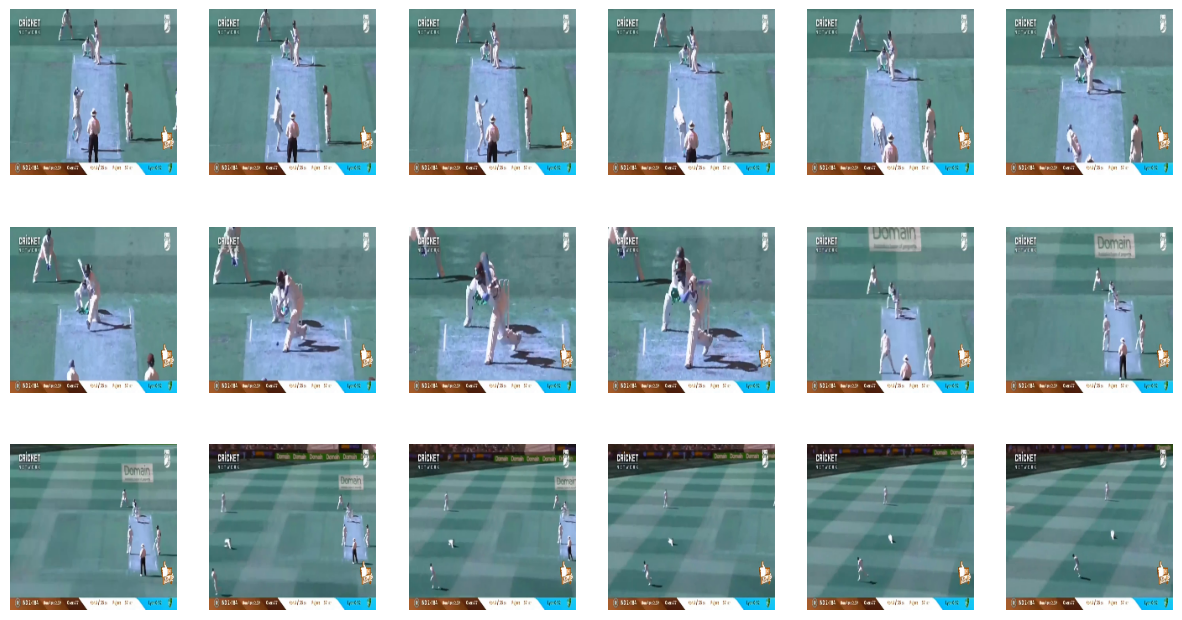

In [8]:
video_path =  f"{path}Cover Drive/(1).mp4"

frames = frames_from_video(video_path, n_frames = 18, interval = 5)

display_frames(frames, nrows=3, ncols=6)

## Load Dataset With Own Input Pipeline

In [9]:
# To create own input pipeline for video data
class FrameGenerator:
  def __init__(self, path, n_frames, shuffle = False):
      
    self.path = Path(path)  # Convert the path to a Path object
    self.n_frames = n_frames
    self.shuffle = shuffle
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths]
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))
    if self.shuffle:
      np.random.seed(42)
      np.random.shuffle(pairs)

    for video_path, name in pairs:
      video_frames = frames_from_video(video_path, self.n_frames, interval=5)
      label = self.class_ids_for_name[name] # Encode labels
      label = tf.keras.utils.to_categorical(label, num_classes=len(self.class_names))  # One-hot encode the label
      yield video_frames, label


In [11]:
# Decide output shape
output_signature = (tf.TensorSpec(shape = (18, 199, 199, 3), dtype = tf.float32), #video frames
                    tf.TensorSpec(shape = (5), dtype = tf.int16))                 # labels

# Create Dataset
dataset = tf.data.Dataset.from_generator(FrameGenerator(path, n_frames=18, shuffle=True),  output_signature = output_signature)

In [12]:
# Count video's
total_samples = sum(1 for _ in dataset)
tf.print(f'Total videos in a Dataset : {total_samples}')

Total videos in a Dataset : 722


# Step 2 : Split Dataset

In [13]:
# Train , Validation, Test Split

# Set the percentages for validation and test (e.g., 20% validation, 10% test)
val_percentage = 0.2
test_percentage = 0.1

# Calculate the number of samples for validation and test
val_size = int(total_samples * val_percentage)
test_size = int(total_samples * test_percentage)

# Create training ,validation,test dataset
train_ds = dataset.skip(val_size + test_size)
val_ds = dataset.take(val_size)
test_ds = dataset.skip(val_size).take(test_size)

## Batch Dataset and Speed up Loading

In [14]:
# Convert Dataset into Batches for fast processing 
batch_size = 16

# Batch the training, validation, and test datasets
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)
test_ds = test_ds.batch(batch_size)

# Use AUTOTUNE to automatically tune the buffer size for optimal performance
AUTOTUNE = tf.data.AUTOTUNE

# Prefetch the datasets to improve data loading speed
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ = test_ds.prefetch(buffer_size = AUTOTUNE)

## Shape of Training, Validation and Test Set

In [15]:
# Retrieve a single batch of video frames and labels from the training dataset using the next function
video_frames, labels = next(iter(train_ds))
tf.print(f'Shape of dataset each batch and label is : {video_frames.shape} and {labels.shape}')

# Count the number of samples
train_samples = sum(batch.shape[0] for batch, label in train_ds)
val_samples = sum(batch.shape[0] for batch, label in val_ds)
test_samples = sum(batch.shape[0] for batch, label in test_ds)

tf.print(f'Total videos in a Dataset : \n Train_Samples : {train_samples} \n val_Samples : {val_samples} \n Test_Samples : {test_samples}')

Shape of dataset each batch and label is : (16, 18, 199, 199, 3) and (16, 5)
Total videos in a Dataset : 
 Train_Samples : 506 
 val_Samples : 144 
 Test_Samples : 72


## Labels 

In [16]:
# Get label names with index
label_names = FrameGenerator(path,n_frames=18)
print(label_names.class_ids_for_name)

{'Bowled': 0, 'Cover Drive': 1, 'Defence': 2, 'Pull Shot': 3, 'Reverse Sweep': 4}


# Step 3 : Model Architecture and Training

## Defining The Architecture of CNN-LSTM Model

In [17]:
# Model Architecture

def cnn_lstm_model(input_shape, num_classes):
    # Input layer
    input_layer = Input(shape=input_shape)
    
    # Convolutional and MaxPooling Layers
    conv1 = TimeDistributed(Conv2D(16, (3, 3), strides=(2, 2), padding='same', activation='relu'))(input_layer)
    pool1 = TimeDistributed(MaxPooling2D((4, 4), strides=(2, 2)))(conv1)

    conv2 = TimeDistributed(Conv2D(32, (3, 3), strides=(2, 2), padding='same', activation='relu'))(pool1)
    pool2 = TimeDistributed(MaxPooling2D((4, 4), strides=(2, 2)))(conv2)

    conv3 = TimeDistributed(Conv2D(64, (3, 3), strides=(2, 2), padding='same', activation='relu'))(pool2)
    pool3 = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)))(conv3)

    conv4 = TimeDistributed(Conv2D(128, (3, 3), strides=(2, 2), padding='same', activation='relu'))(pool3)
    pool4 = TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2)))(conv4)

    # Flatten Layer
    flatten_layer = TimeDistributed(Flatten())(pool4)

    # LSTM Layer
    lstm_layer = LSTM(128, return_sequences=False)(flatten_layer)

    # Fully Connected Layer
    dense_layer = Dense(128, activation='relu')(lstm_layer)

    # Output Layer
    output_layer = Dense(num_classes, activation='softmax')(dense_layer)

    # Create Model
    model = Model(inputs=input_layer, outputs=output_layer)

    return model

## Define Optimizer and Loss Function

In [18]:
# Create the model
model = cnn_lstm_model(input_shape=(18, 199, 199, 3), num_classes=5)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 18, 199, 199, 3   0         
                             )]                                  
                                                                 
 time_distributed (TimeDist  (None, 18, 100, 100, 16   448       
 ributed)                    )                                   
                                                                 
 time_distributed_1 (TimeDi  (None, 18, 49, 49, 16)    0         
 stributed)                                                      
                                                                 
 time_distributed_2 (TimeDi  (None, 18, 25, 25, 32)    4640      
 stributed)                                                      
                                                                 
 time_distributed_3 (TimeDi  (None, 18, 11, 11, 32)    0     

## Train a CNN-LSTM Model

In [19]:
# Model Training
start_time = time.time()

history = model.fit(train_ds, epochs=30, validation_data=val_ds,
                    callbacks = tf.keras.callbacks.EarlyStopping(patience = 3, monitor = 'val_loss',restore_best_weights=True))

end_time = time.time()

# Calculate the training time
time_taken = end_time - start_time
tf.print(f"Time taken for video: {time_taken:.4f} seconds")

Epoch 1/30


I0000 00:00:1709899282.242611   21686 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 [==============================] - 86s 2s/step - loss: 1.3551 - accuracy: 0.3696 - val_loss: 1.1713 - val_accuracy: 0.4444
Epoch 2/30
32/32 [==============================] - 77s 2s/step - loss: 1.2322 - accuracy: 0.3874 - val_loss: 1.1329 - val_accuracy: 0.5139
Epoch 3/30
32/32 [==============================] - 72s 2s/step - loss: 1.1023 - accuracy: 0.4862 - val_loss: 0.9021 - val_accuracy: 0.5139
Epoch 4/30
32/32 [==============================] - 87s 2s/step - loss: 0.9402 - accuracy: 0.5514 - val_loss: 0.8388 - val_accuracy: 0.5694
Epoch 5/30
32/32 [==============================] - 77s 2s/step - loss: 0.8184 - accuracy: 0.6126 - val_loss: 0.8498 - val_accuracy: 0.5556
Epoch 6/30
32/32 [==============================] - 77s 2s/step - loss: 0.6705 - accuracy: 0.7273 - val_loss: 0.5024 - val_accuracy: 0.7569
Epoch 7/30
32/32 [==============================] - 87s 2s/step - loss: 0.5153 - accuracy: 0.7846 - val_loss: 0.5804 - val_accuracy: 0.7639
Epoch 8/30
32/32 [=============

# Step 4 : Model Evaluation

## Monitoring Training and Validation Error

In [22]:
def plot_loss_acc_curve(history):
    
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 12)

  # Plot loss
  ax1.set_title('Training and Validation Loss Curve')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'val')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  # Determine upper bound of y-axis
  max_loss = max(max(history.history['loss']) , max(history.history['val_loss']))
  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.legend(['Train', 'Validation'])
  
    
  # Plot accuracy
  ax2.set_title('Training and Validation Accuracy Curve')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'val')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.legend(['Train', 'Validation'])

  plt.show()

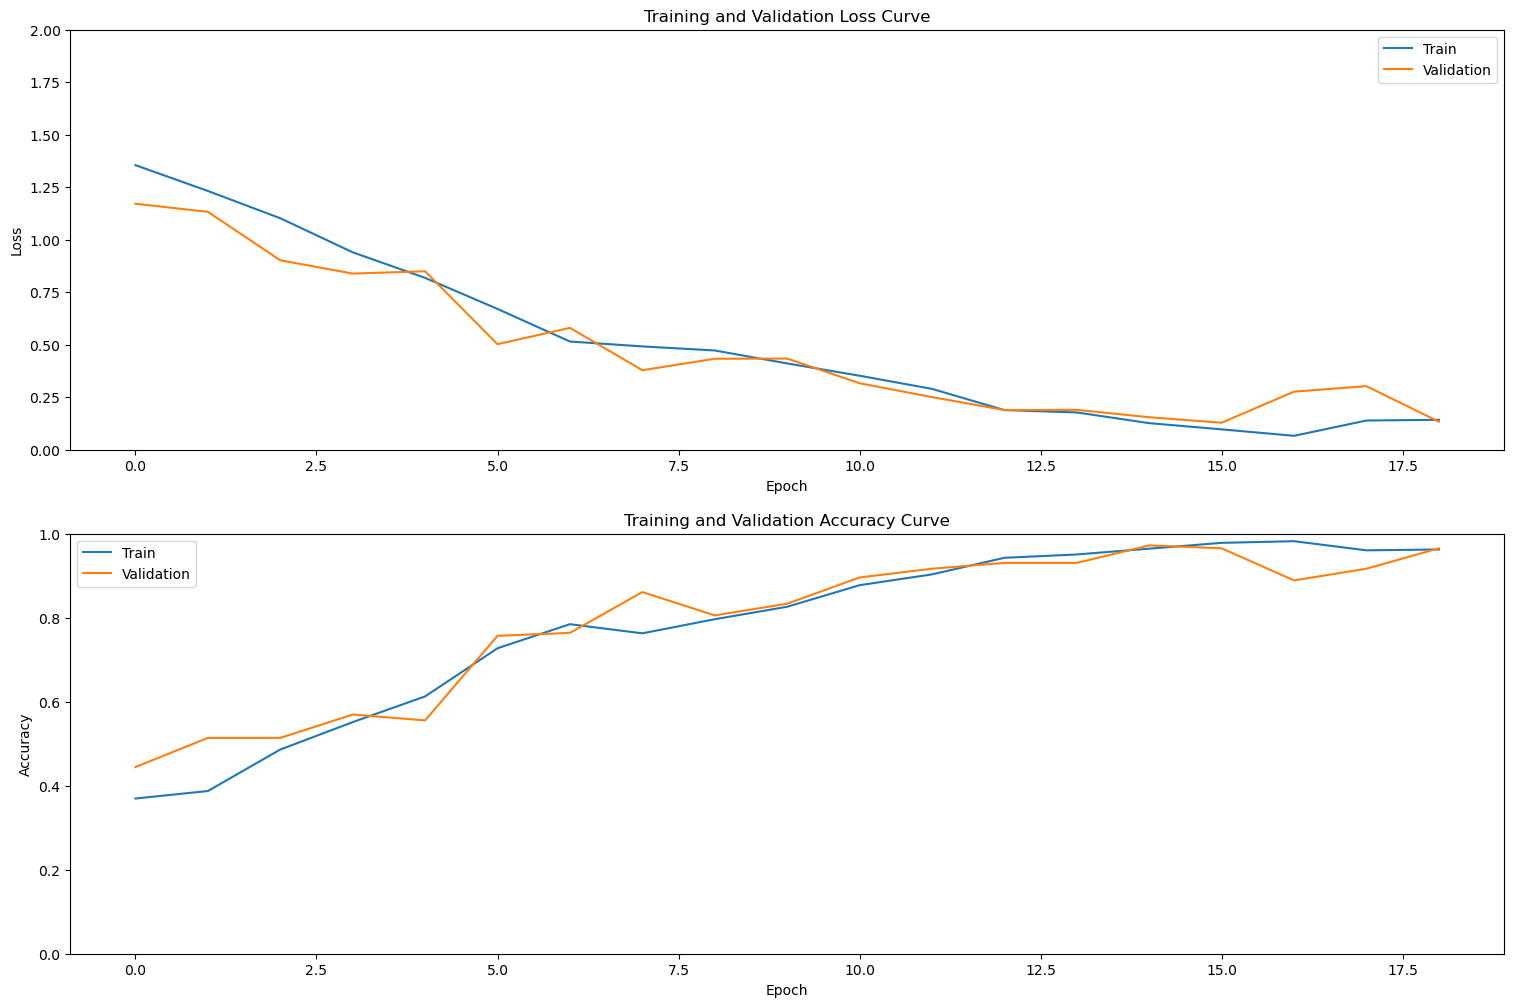

In [23]:
# plot curve
plot_loss_acc_curve(history)

## Performance Evaluation Metric

In [24]:
# Evaluate the model
def evaluate_model(ds, ds_type):
    loss, accuracy = model.evaluate(ds,verbose=0)
    tf.print(f'{ds_type} set Accuracy: {accuracy * 100:.2f}%')

In [25]:
# Evaluate on Train set
evaluate_model(train_ds, ds_type="Training")

# Evaluate on Train set
evaluate_model(val_ds, ds_type="Validation")

# Evaluate on Train set
evaluate_model(test_ds, ds_type="Test")

Training set Accuracy: 98.42%
Validation set Accuracy: 96.53%
Test set Accuracy: 94.44%


## Classification Report

In [26]:
# Classsifiaction report
def precision_recall_f1_score(ds, ds_type):
    actual = np.concatenate([labels for frames,labels in ds])
    actual= np.argmax(actual, axis=1)
    
    predicted = np.concatenate([model.predict(frames,verbose=0) for frames,labels in ds])
    predicted = np.argmax(predicted, axis=1)
    
    # Generate the classification report
    labels = label_names.class_names
    report = classification_report(actual, predicted, target_names=labels)
    # report = classification_report(actual, predicted)
    tf.print(f'{ds_type} set Classification report: \n {report}')

In [27]:
# Plot Training report
precision_recall_f1_score(train_ds, ds_type="Training")

# Plot Validation report
precision_recall_f1_score(val_ds, ds_type="Validation")

# Plot Test report
precision_recall_f1_score(test_ds, ds_type="Test")

Training set Classification report: 
                precision    recall  f1-score   support

       Bowled       0.98      1.00      0.99       104
  Cover Drive       0.97      0.97      0.97       109
      Defence       1.00      0.99      1.00       107
    Pull Shot       1.00      0.99      1.00       106
Reverse Sweep       0.96      0.96      0.96        80

     accuracy                           0.98       506
    macro avg       0.98      0.98      0.98       506
 weighted avg       0.98      0.98      0.98       506

Validation set Classification report: 
                precision    recall  f1-score   support

       Bowled       0.91      1.00      0.95        29
  Cover Drive       0.96      0.96      0.96        26
      Defence       1.00      0.93      0.97        30
    Pull Shot       1.00      1.00      1.00        29
Reverse Sweep       0.97      0.93      0.95        30

     accuracy                           0.97       144
    macro avg       0.97      0.97   

## Plot Confusion Matrix

In [28]:
# Confusion matrix
def plot_confusion_matrix(ds, ds_type):
  actual = np.concatenate([labels for frames,labels in ds])
  actual= np.argmax(actual, axis=1)
    
  predicted = np.concatenate([model.predict(frames,verbose=0) for frames,labels in ds])
  predicted = np.argmax(predicted, axis=1)
  labels = label_names.class_names
  cm = tf.math.confusion_matrix(actual, predicted)
  plt.figure(figsize=(6, 4))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
  plt.xlabel('Predicted labels')
  plt.ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  plt.title('Confusion matrix of action recognition for ' + ds_type+' set')
  plt.show()

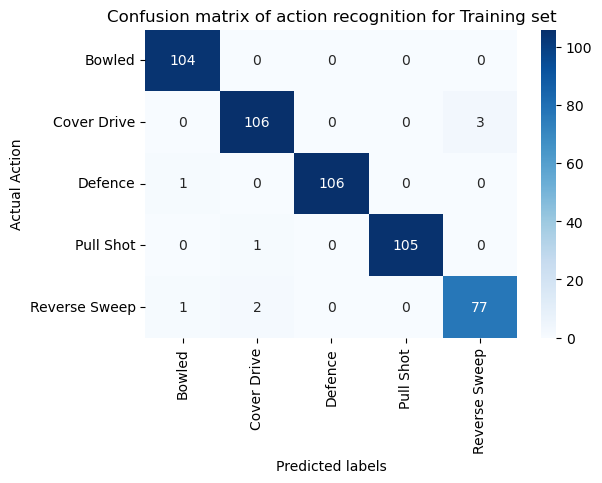

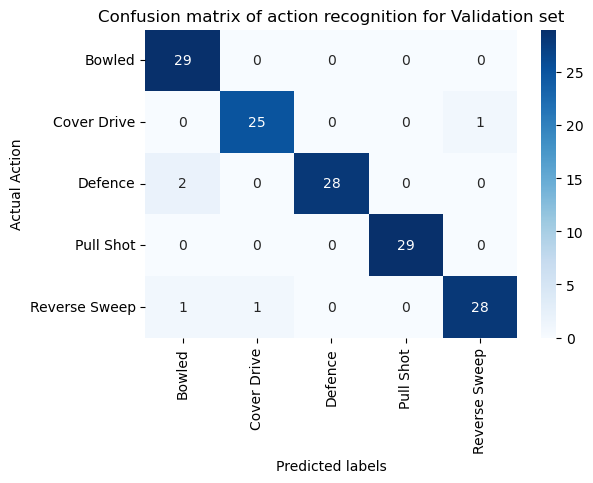

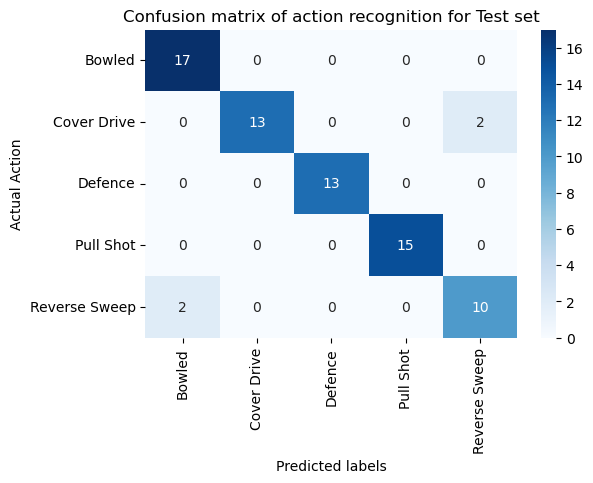

In [29]:
# confusion matrix for Training set
plot_confusion_matrix(train_ds, ds_type='Training')

# confusion matrix for Validation set
plot_confusion_matrix(val_ds, ds_type='Validation')

# confusion matrix for Test set
plot_confusion_matrix(test_ds, ds_type='Test')

## Save Model

In [30]:
#save model
model.save('v_model.keras')
tf.print('Model Saved!')

Model Saved!


In [31]:
# load model
#model=load_model('v_model.keras')
# tf.print('Model Loaded!')
#model.summary()

# Step 5 : Prediction on Video

## Create a Function for Prediction

In [32]:
# Define a list of colors for visualization
colors = [(245,117,16), (117,245,16), (16,117,245),(200,103,27),(117,245,16)]

# Function to visualize probabilities on the frame
def prob_viz(pred_probs, labels, frame, colors=colors):
    output_frame = frame.copy()
    for num, prob in enumerate(pred_probs[0]):
        cv2.rectangle(output_frame, (0,60+num*30), (int(prob*100), 90+num*30), colors[num], -1)
        cv2.putText(output_frame, labels[num], (0, 85+num*30), 
                    cv2.FONT_HERSHEY_COMPLEX_SMALL    , 0.8, (255,255,255), 1, cv2.LINE_AA)
        
    return output_frame

In [33]:
# Prediction Function
def prediction_on_video(model, path, window_size=3, step_size=3, interval=5, n_frames=18):

    # Map the predicted class to the corresponding shot category based on your label encoding
    labels = ['Bowled', 'Cover Drive', 'Defence', 'Pull Shot', 'Reverse Sweep']

    records_pred = []
    pred_probs = [[0, 0, 0, 0, 0]]
    pred_shot = ""

    # Open a video capture object
    cap = cv2.VideoCapture(path)  # Replace with the path to your video file

    # Create a video writer object for saving the predicted result
    video = cv2.VideoWriter('predicted_result.mp4', cv2.VideoWriter_fourcc(*'mp4v'), 20, (840, 480))

    start_time = 0
    end = 0

    while True:
        # Set the video capture to the start time
        cap.set(cv2.CAP_PROP_POS_FRAMES, int(start_time * cap.get(cv2.CAP_PROP_FPS)))

        frames = []
        frame_counter = 0

        while len(frames) < n_frames:
            success, frame = cap.read()

            if not success:
                end = 1
                break

            frame = cv2.resize(frame, (840, 480))
            out_frame = cv2.resize(frame, (840, 480))
            last_frame = cv2.resize(frame, (840, 480))

            if frame_counter % interval == 0:
                frame = cv2.resize(frame, (199, 199))
                frames.append(frame)

            frame_counter += 1

            out_frame = prob_viz(pred_probs, labels, out_frame)
            cv2.rectangle(out_frame, (0, 0), (840, 30), (245, 117, 16), -1)
            cv2.putText(out_frame, ' '.join(records_pred[-4:]), (3, 25),
                        cv2.FONT_HERSHEY_TRIPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)

            video.write(out_frame)

            cv2.imshow('Cricket PoseNet : AI Shot Assistant', out_frame)
            cv2.waitKey(20)

        # Pad or trim frames to have a consistent length of max_frames
        frames = frames + [np.zeros_like(frames[0])] * max(0, n_frames - len(frames))

        # Prediction
        pred_probs = model.predict(np.array([frames]), verbose=0)
        pred_class = np.argmax(pred_probs, axis=1)
        pred_shot = labels[pred_class[0]]
        records_pred.append(pred_shot)

        if end:
            out_frame = prob_viz(pred_probs, labels, last_frame)
            cv2.rectangle(out_frame, (0, 0), (840, 30), (245, 117, 16), -1)
            cv2.putText(out_frame, ' '.join(records_pred[-4:]), (3, 25),
                        cv2.FONT_HERSHEY_TRIPLEX, 0.8, (255, 255, 255), 1, cv2.LINE_AA)

            cv2.imshow('Cricket PoseNet : AI Shot Assistant', out_frame)
            cv2.waitKey(2000)
            for i in range(10):
                video.write(out_frame)
            break

        # Update the time for the next window
        start_time += step_size

        # Break the loop if 'q' is pressed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

    # Release the video capture object
    video.release()
    cap.release()
    cv2.destroyAllWindows()

    return records_pred

## Showing Prediction

In [44]:
# Take prediction using webcam by  set path=0 or prediction on video by set path = "folder/video.mp4"  
prediction_on_video(model,path="/home/umair-pc/Downloads/test1.mp4")

['Cover Drive', 'Defence', 'Pull Shot', 'Reverse Sweep']